# Late Fusion by Ambiguity Groups - BALANCED

This notebook splits trials into ambiguity groups with **STRATIFIED SAMPLING** to ensure each subject contributes equally to each group.

**Parameterized**: Set `TIMEFRAME` to run PRE or POST analysis.

In [1]:
# ============================================================================
# CONFIGURATION: Set timeframe for analysis
# ============================================================================
TIMEFRAME = 'POST'  # Options: 'PRE', 'POST'
# ============================================================================

import sys
sys.path.append('../..')  # Add project root to path

import pickle
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, f1_score
from sklearn.impute import SimpleImputer
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Import from src package
from src.models.fusion import weighted_late_fusion

np.random.seed(42)
sns.set_style('whitegrid')

print(f"\n{'='*70}")
print(f"AMBIGUITY GROUP (BALANCED) ANALYSIS: {TIMEFRAME}-DECISION PERIOD")
print(f"{'='*70}\n")


AMBIGUITY GROUP (BALANCED) ANALYSIS: POST-DECISION PERIOD



## 1. Load Pre-Extracted Features

In [2]:
# Load pre-extracted features
with open(f'../../data/results/features_{TIMEFRAME}/extracted_features_{TIMEFRAME}.pkl', 'rb') as f:
    feature_data = pickle.load(f)

merged_df = feature_data['merged_df']
physio_cols = feature_data['physio_cols']
behavior_cols = feature_data['behavior_cols']
gaze_cols = feature_data['gaze_cols']

print(f"✓ Loaded {len(merged_df)} trials from {merged_df['subject_id'].nunique()} subjects")
print(f"  Features extracted on: {feature_data['metadata']['extraction_date']}")
print(f"\nAmbiguity distribution:")
print(merged_df['ambiguity'].value_counts().sort_index())

✓ Loaded 11467 trials from 97 subjects
  Features extracted on: 2026-01-01 18:36:39

Ambiguity distribution:
ambiguity
0    3830
3    3820
6    3817
Name: count, dtype: int64


## 2. Create Ambiguity Groups with Stratified Sampling

In [3]:
# Create ambiguity groups
merged_df['ambiguity_group'] = merged_df['ambiguity'].replace({0:'Low', 3:'Medium', 6:'High'})

print("Original ambiguity group distribution:")
print(merged_df['ambiguity_group'].value_counts())

# Perform stratified sampling to balance subjects across groups
print("\n" + "="*80)
print("STRATIFIED SAMPLING: Ensuring equal subject representation")
print("="*80)

balanced_data = []
for group in ['Low', 'Medium', 'High']:
    group_data = merged_df[merged_df['ambiguity_group'] == group].copy()
    
    # Find minimum trials per subject in this group
    subject_counts = group_data.groupby('subject_id').size()
    min_trials = subject_counts.min()
    
    print(f"\n{group} Ambiguity:")
    print(f"  Original: {len(group_data)} trials")
    print(f"  Min trials per subject: {min_trials}")
    print(f"  Sampling {min_trials} trials from each of {subject_counts.nunique()} subjects")
    
    # Sample exactly min_trials from each subject
    balanced_group_data = []
    for subject in group_data['subject_id'].unique():
        subject_data = group_data[group_data['subject_id'] == subject]
        sampled = subject_data.sample(n=min_trials, random_state=42)
        balanced_group_data.append(sampled)
    
    balanced_group = pd.concat(balanced_group_data, ignore_index=True)
    print(f"  After balancing: {len(balanced_group)} trials ({len(balanced_group) / len(group_data) * 100:.1f}% of original)")
    balanced_data.append(balanced_group)

merged_df_balanced = pd.concat(balanced_data, ignore_index=True)

print(f"\n{'='*80}")
print(f"SUMMARY:")
print(f"  Original total: {len(merged_df)} trials")
print(f"  Balanced total: {len(merged_df_balanced)} trials")
print(f"  Data retained: {len(merged_df_balanced) / len(merged_df) * 100:.1f}%")
print(f"  Data lost: {(1 - len(merged_df_balanced) / len(merged_df)) * 100:.1f}%")
print(f"\nBalanced distribution:")
print(merged_df_balanced['ambiguity_group'].value_counts())

Original ambiguity group distribution:
ambiguity_group
Low       3830
Medium    3820
High      3817
Name: count, dtype: int64

STRATIFIED SAMPLING: Ensuring equal subject representation

Low Ambiguity:
  Original: 3830 trials
  Min trials per subject: 4
  Sampling 4 trials from each of 21 subjects
  After balancing: 388 trials (10.1% of original)

Medium Ambiguity:
  Original: 3820 trials
  Min trials per subject: 2
  Sampling 2 trials from each of 19 subjects
  After balancing: 194 trials (5.1% of original)

High Ambiguity:
  Original: 3817 trials
  Min trials per subject: 3
  Sampling 3 trials from each of 22 subjects
  After balancing: 291 trials (7.6% of original)

SUMMARY:
  Original total: 11467 trials
  Balanced total: 873 trials
  Data retained: 7.6%
  Data lost: 92.4%

Balanced distribution:
ambiguity_group
Low       388
High      291
Medium    194
Name: count, dtype: int64


## 3. Prepare Feature Sets

In [4]:
physio_cols = [c for c in merged_df_balanced.columns if c.endswith('_pre')]
behavior_cols = ['reaction_time', 'decision_time', 'ev_difference', 
                 'invest_variance', 'condition_social', 'risk_premium']
gaze_cols = [c for c in merged_df_balanced.columns 
             if c.startswith('gaze_') or c.startswith('screen_') or 
             c in ['fixation_ratio', 'saccade_ratio', 'saccade_count', 'gaze_valid_pct',
                   'gaze_dispersion_x', 'gaze_dispersion_y', 'gaze_path_length']]

print(f"Physiology ({TIMEFRAME}): {len(physio_cols)} features")
print(f"Behavior: {len(behavior_cols)} features")
print(f"Gaze: {len(gaze_cols)} features")

Physiology (POST): 0 features
Behavior: 6 features
Gaze: 0 features


## 4. Run Weighted Late Fusion on BALANCED Data

In [5]:
# Run late fusion for each ambiguity group
group_results = {}

for group in ['Low', 'Medium', 'High']:
    print(f"\n{'='*80}")
    print(f"Analyzing {group} Ambiguity Group")
    print(f"{'='*80}")
    
    # Filter data for this group
    group_df = merged_df_balanced[merged_df_balanced['ambiguity_group'] == group].copy()
    
    # Prepare feature matrices
    X_physio = group_df[physio_cols].values if len(physio_cols) > 0 else np.zeros((len(group_df), 1))
    X_behavior = group_df[behavior_cols].values
    X_gaze = group_df[gaze_cols].values if len(gaze_cols) > 0 else np.zeros((len(group_df), 1))
    
    # Handle missing values
    imputer = SimpleImputer(strategy='mean')
    X_physio = imputer.fit_transform(X_physio)
    X_behavior = imputer.fit_transform(X_behavior)
    X_gaze = imputer.fit_transform(X_gaze)
    
    y = group_df['outcome'].values
    subjects = group_df['subject_id'].values
    
    # Setup modalities based on available data
    if len(gaze_cols) > 0:
        X_modalities = [X_physio, X_behavior, X_gaze]
        modality_names = ['Physiology', 'Behavior', 'Gaze']
    else:
        # POST condition: no gaze data
        X_modalities = [X_physio, X_behavior]
        modality_names = ['Physiology', 'Behavior']
    
    print(f"\nRunning weighted late fusion for {group} group...")
    print(f"  N trials: {len(y)}")
    print(f"  N subjects: {len(np.unique(subjects))}")
    
    # Run fusion
    results = weighted_late_fusion(X_modalities, y, subjects, modality_names)
    group_results[group] = results
    
    print(f"\nResults for {group} group:")
    print(f"  Accuracy: {results['accuracy_mean']:.3f} ± {results['accuracy_sem']:.3f} (SEM)")
    print(f"  F1-Score: {results['f1_mean']:.3f} ± {results['f1_sem']:.3f} (SEM)")
    print(f"  Weights: {dict(zip(modality_names, results['weights']))}")


Analyzing Low Ambiguity Group

Running weighted late fusion for Low group...
  N trials: 388
  N subjects: 97

Results for Low group:
  Accuracy: 0.830 ± 0.026 (SEM)
  F1-Score: 0.786 ± 0.030 (SEM)
  Weights: {'Physiology': np.float64(0.007031833537071485), 'Behavior': np.float64(0.9929681664629286)}

Analyzing Medium Ambiguity Group

Running weighted late fusion for Medium group...
  N trials: 194
  N subjects: 97

Results for Medium group:
  Accuracy: 0.675 ± 0.036 (SEM)
  F1-Score: 0.639 ± 0.039 (SEM)
  Weights: {'Physiology': np.float64(0.014748644569992963), 'Behavior': np.float64(0.985251355430007)}

Analyzing High Ambiguity Group

Running weighted late fusion for High group...
  N trials: 291
  N subjects: 97

Results for High group:
  Accuracy: 0.584 ± 0.031 (SEM)
  F1-Score: 0.605 ± 0.032 (SEM)
  Weights: {'Physiology': np.float64(0.007611571889449792), 'Behavior': np.float64(0.9923884281105502)}


## 5. Compare Results Across Groups

In [6]:
comparison_df = pd.DataFrame([
    {
        'Group': group,
        'N_Trials': results['n_trials'],
        'N_Subjects': results['n_subjects'],
        'Accuracy': results['accuracy_mean'],
        'Accuracy_SEM': results['accuracy_sem'],
        'Accuracy_SD': results['accuracy_std'],
        'F1-Score': results['f1_mean'],
        'F1_SEM': results['f1_sem'],
        'Physiology_Weight': results['weights'][0] if len(results['weights']) > 0 else 0,
        'Behavior_Weight': results['weights'][1] if len(results['weights']) > 1 else 0,
        'Gaze_Weight': results['weights'][2] if len(results['weights']) > 2 else 0
    }
    for group, results in group_results.items()
])

print("\n" + "="*80)
print("COMPARISON ACROSS AMBIGUITY GROUPS (BALANCED DATA with SEM)")
print("="*80)
print(comparison_df[['Group', 'N_Trials', 'N_Subjects', 'Accuracy', 'Accuracy_SEM', 'Accuracy_SD']].to_string(index=False))

print("\n" + "="*80)
print("NOTE: Using BALANCED/STRATIFIED data")
print("- Each subject contributes EQUALLY to each ambiguity group")
print("- Error bars use SEM (Standard Error of Mean) from subject-level accuracies")
print("- No subject imbalance bias in LOSO CV")
print("="*80)


COMPARISON ACROSS AMBIGUITY GROUPS (BALANCED DATA with SEM)
 Group  N_Trials  N_Subjects  Accuracy  Accuracy_SEM  Accuracy_SD
   Low       388          97  0.829897      0.025789     0.252682
Medium       194          97  0.675258      0.035929     0.352028
  High       291          97  0.584192      0.030908     0.302835

NOTE: Using BALANCED/STRATIFIED data
- Each subject contributes EQUALLY to each ambiguity group
- Error bars use SEM (Standard Error of Mean) from subject-level accuracies
- No subject imbalance bias in LOSO CV


## 6. Visualizations

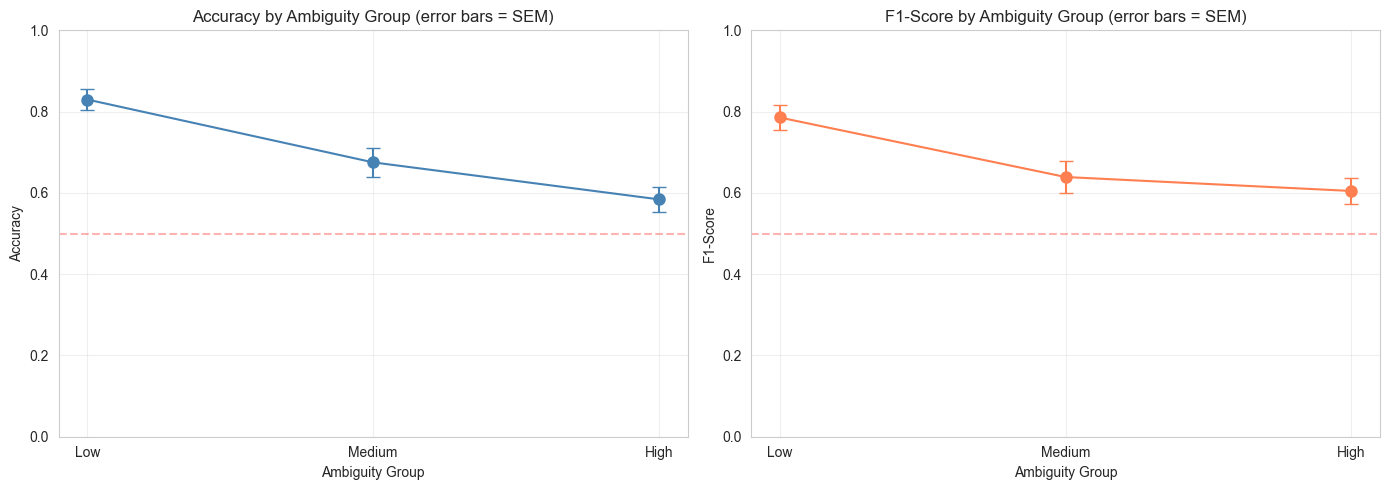

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy with SEM error bars
ax = axes[0]
ax.errorbar(comparison_df['Group'], comparison_df['Accuracy'], 
            yerr=comparison_df['Accuracy_SEM'], fmt='o-', capsize=5, color='steelblue', markersize=8)
ax.set_xlabel('Ambiguity Group')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by Ambiguity Group (error bars = SEM)')
ax.set_ylim([0, 1])
ax.axhline(0.5, color='red', linestyle='--', alpha=0.3)
ax.grid(alpha=0.3)

# F1-Score with SEM error bars
ax = axes[1]
ax.errorbar(comparison_df['Group'], comparison_df['F1-Score'], 
            yerr=comparison_df['F1_SEM'], fmt='o-', capsize=5, color='coral', markersize=8)
ax.set_xlabel('Ambiguity Group')
ax.set_ylabel('F1-Score')
ax.set_title('F1-Score by Ambiguity Group (error bars = SEM)')
ax.set_ylim([0, 1])
ax.axhline(0.5, color='red', linestyle='--', alpha=0.3)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Subject-Level Accuracy Distributions

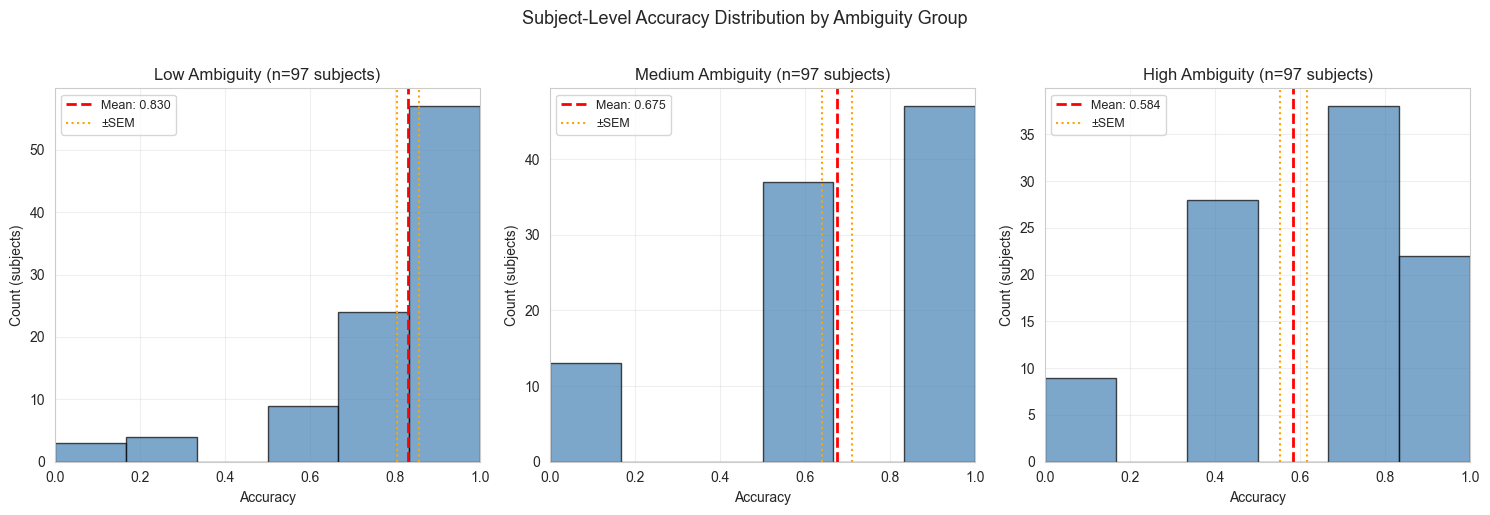

In [8]:
# Plot subject-level accuracy distributions for each ambiguity group
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, (group, results) in enumerate(group_results.items()):
    ax = axes[idx]
    subject_accs = results['accuracy_per_subject']
    
    # Histogram
    ax.hist(subject_accs, bins=6, color='steelblue', alpha=0.7, edgecolor='black')
    ax.axvline(results['accuracy_mean'], color='red', linestyle='--', linewidth=2,
               label=f"Mean: {results['accuracy_mean']:.3f}")
    ax.axvline(results['accuracy_mean'] - results['accuracy_sem'], color='orange',
               linestyle=':', linewidth=1.5, label=f"±SEM")
    ax.axvline(results['accuracy_mean'] + results['accuracy_sem'], color='orange',
               linestyle=':', linewidth=1.5)
    
    ax.set_xlabel('Accuracy')
    ax.set_ylabel('Count (subjects)')
    ax.set_title(f'{group} Ambiguity (n={results["n_subjects"]} subjects)')
    ax.set_xlim([0, 1])
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)

plt.suptitle('Subject-Level Accuracy Distribution by Ambiguity Group', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

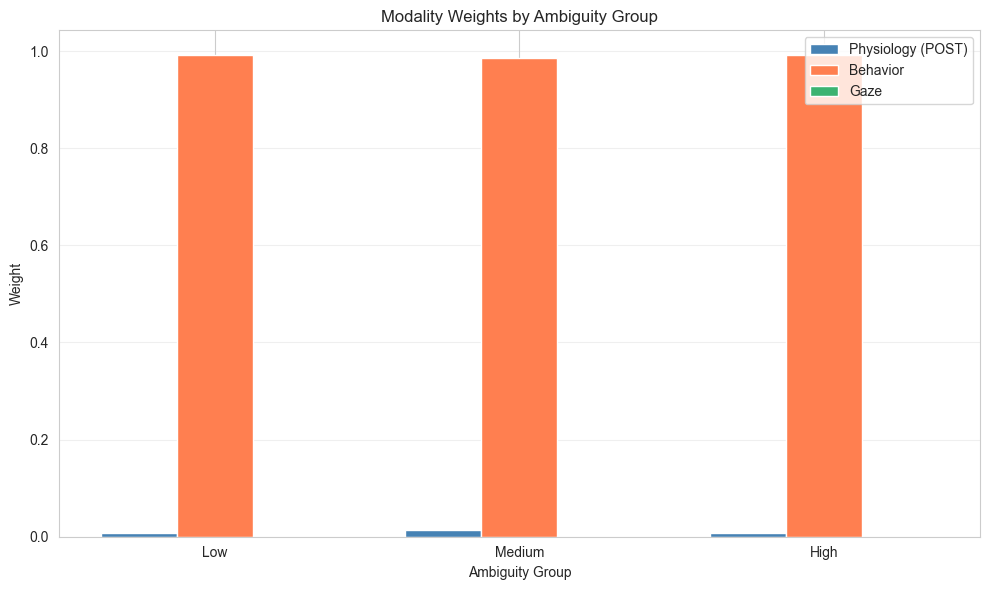

In [9]:
# Modality weights by group
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(comparison_df))
width = 0.25

ax.bar(x - width, comparison_df['Physiology_Weight'], width, 
       label=f'Physiology ({TIMEFRAME})', color='steelblue')
ax.bar(x, comparison_df['Behavior_Weight'], width, 
       label='Behavior', color='coral')
ax.bar(x + width, comparison_df['Gaze_Weight'], width, 
       label='Gaze', color='mediumseagreen')

ax.set_xlabel('Ambiguity Group')
ax.set_ylabel('Weight')
ax.set_title('Modality Weights by Ambiguity Group')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Group'])
ax.legend()
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 8. Save Results to CSV

Exporting all results for later analysis without re-running.

In [10]:
import os
os.makedirs(f'../../data/results/fusion_model_results_{TIMEFRAME}', exist_ok=True)

# Save comparison results across groups
if 'comparison_df' in locals() and comparison_df is not None:
    output_file = f'../../data/results/fusion_model_results_{TIMEFRAME}/ambiguity_group_late_fusion_balanced_{TIMEFRAME}_comparison.csv'
    comparison_df.to_csv(output_file, index=False)
    print(f"✓ Saved comparison results to: {output_file}")
    print(f"  Contains {len(comparison_df)} groups")

# Save detailed group results
if 'group_results' in locals() and group_results:
    for group_name, results in group_results.items():
        # Save modality weights
        modality_names = results.get('modality_names', ['Physiology', 'Behavior', 'Gaze'][:len(results['weights'])])
        weights_df = pd.DataFrame({
            'Modality': modality_names,
            'Weight': results['weights']
        })
        weights_file = f'../../data/results/fusion_model_results_{TIMEFRAME}/ambiguity_group_late_fusion_balanced_{TIMEFRAME}_{group_name}_weights.csv'
        weights_df.to_csv(weights_file, index=False)

        # Save subject-level accuracies if available
        if 'accuracy_per_subject' in results:
            subject_df = pd.DataFrame({
                'accuracy': results['accuracy_per_subject'],
                'f1_score': results.get('f1_per_subject', [])
            })
            subject_file = f'../../data/results/fusion_model_results_{TIMEFRAME}/ambiguity_group_late_fusion_balanced_{TIMEFRAME}_{group_name}_subject_accuracies.csv'
            subject_df.to_csv(subject_file, index=False)

    print(f"✓ Saved detailed results for {len(group_results)} groups")

print(f"\nAll results saved to: ../../data/results/fusion_model_results_{TIMEFRAME}/")

✓ Saved comparison results to: ../../data/results/fusion_model_results_POST/ambiguity_group_late_fusion_balanced_POST_comparison.csv
  Contains 3 groups
✓ Saved detailed results for 3 groups

All results saved to: ../../data/results/fusion_model_results_POST/
